In [138]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

The data transformation code is from : https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [139]:
df = pd.read_csv('final.csv', index_col= 'Unnamed: 0')
df = df.head(2420)
df.shape

(2420, 8)

In [140]:
#Define input sequence
in_seq1 = array(df['Open'])
in_seq2 = array(df['High'])
in_seq3 = array(df['Low'])
in_seq4 = array(df['TMAX'])
in_seq5 = array(df['TMIN'])
in_seq6 = array(df['PRCP'])
in_seq7 = array(df['SNOW'])
out_seq = array(df['Price'])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq2,in_seq3,in_seq1,in_seq4,in_seq5,in_seq6,in_seq7, out_seq))
dataset[0]

array([0.22180801, 0.21514135, 0.21533365, 0.15092663, 0.125927  ,
       0.00784088, 0.05064523, 0.2208589 ])

In [141]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [142]:
n_steps=5
X, y = split_sequences(dataset, n_steps)
X_train = X[0:-100]
X_test = X[-101:-1]
y_train = y[0:-100]
y_test = y[-101:-1]
n_features = X_train.shape[2]

In [143]:
X_train.shape

(2316, 5, 7)

In [144]:
y_train.shape

(2316,)

the hyper parameters are comming from the optimizer model in the other notebook 

In [147]:
# define model
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(304, return_sequences=True, input_shape=(n_steps, n_features), activation='relu'),
        tf.keras.layers.Dropout(0.053661),
        tf.keras.layers.LSTM(304,
                  return_sequences=True, activation='relu'),
        tf.keras.layers.Dropout(0.053661),
        tf.keras.layers.LSTM(304,
                  return_sequences=True, activation='relu'),
        tf.keras.layers.Dropout(0.053661),
        tf.keras.layers.LSTM(304,
                  return_sequences=True, activation='relu'),
        tf.keras.layers.Dropout(0.053661),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(304, activation='relu'),
        tf.keras.layers.Dense(304, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
model.summary()
adam=tf.keras.optimizers.Adam(lr=0.004687, epsilon=None, amsgrad=True, decay=0.000129)
model.compile(loss ='mean_squared_error', optimizer=adam, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=60, batch_size=85, verbose=1)

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_224 (LSTM)              (None, 5, 304)            379392    
_________________________________________________________________
dropout_224 (Dropout)        (None, 5, 304)            0         
_________________________________________________________________
lstm_225 (LSTM)              (None, 5, 304)            740544    
_________________________________________________________________
dropout_225 (Dropout)        (None, 5, 304)            0         
_________________________________________________________________
lstm_226 (LSTM)              (None, 5, 304)            740544    
_________________________________________________________________
dropout_226 (Dropout)        (None, 5, 304)            0         
_________________________________________________________________
lstm_227 (LSTM)              (None, 5, 304)          

2316/2316 [==============================] - 1s 639us/sample - loss: 8.3678e-04 - accuracy: 8.6356e-04
Epoch 57/60
2316/2316 [==============================] - 2s 681us/sample - loss: 6.6563e-04 - accuracy: 8.6356e-04
Epoch 58/60
2316/2316 [==============================] - 2s 652us/sample - loss: 7.5543e-04 - accuracy: 8.6356e-04
Epoch 59/60
2316/2316 [==============================] - 2s 694us/sample - loss: 7.1562e-04 - accuracy: 8.6356e-04
Epoch 60/60
2316/2316 [==============================] - 2s 691us/sample - loss: 5.7935e-04 - accuracy: 8.6356e-04


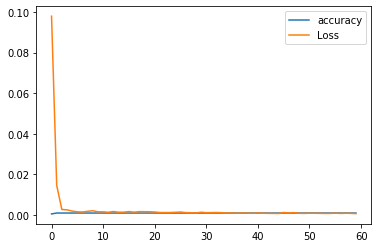

In [148]:
plt.plot(history.history['accuracy'], label ='accuracy')
plt.plot(history.history['loss'], label ='Loss')
plt.legend()

In [149]:
yhat = model.predict(X_test, verbose=1)

100/100 [==============================] - 1s 6ms/sample


In [150]:
from sklearn.preprocessing import MinMaxScaler
results = np.array(yhat).reshape(100,1)
y_test_scaled = np.array(y_test).reshape(100,1)
pred = pd.DataFrame(results)
true = pd.DataFrame(y_test_scaled)
date_rng = pd.date_range(start='22-09-2018', end='31-12-2018', freq='D')
dq = pd.DataFrame(date_rng, columns=['date'])
pred['Date'] = dq
pred.columns = ['Predictions', 'Date']
true['Date'] = dq
true.columns = ['Actual', 'Date']
final_results = pd.merge(pred, true, on='Date')
final_results.set_index(final_results.Date, inplace = True)
final_results.drop('Date', axis=1, inplace=True)
final_results['Difference %'] = ((final_results.Actual- final_results.Predictions)/final_results.Actual)
final_results['Difference'] = (final_results.Actual- final_results.Predictions)
final_results.head()

,Predictions,Actual,Difference %,Difference
Date,,,,
2018-09-22,0.123238,0.106182,-0.160624,-0.017055
2018-09-23,0.114077,0.103823,-0.098768,-0.010254
2018-09-24,0.109129,0.114677,0.048380,0.005548
2018-09-25,0.109123,0.113261,0.036536,0.004138
2018-09-26,0.110410,0.120340,0.082517,0.009930


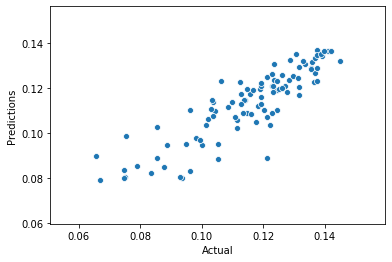

In [151]:
sns.scatterplot('Actual', 'Predictions', data=final_results)

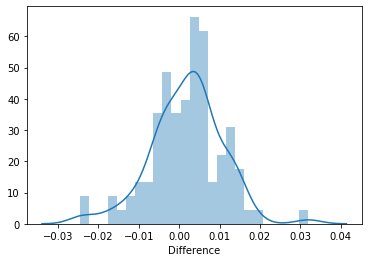

In [152]:
sns.distplot(final_results.Difference, bins=25)

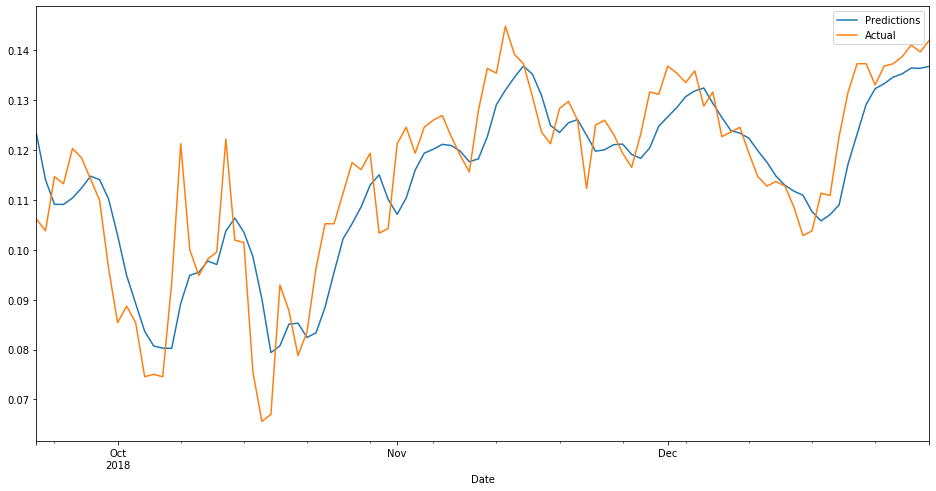

In [153]:
final_results.Predictions.plot( figsize=(16,8))
final_results.Actual.plot()
plt.legend()